<a href="https://colab.research.google.com/github/jashwanth15/Machine-Learning/blob/main/Resume_Selector_with_Naive_Bayes_AP23110011398.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK #1: UNDERSTAND THE PROBLEM AND BUSINESS CASE

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


![image.png](attachment:image.png)

In [22]:
# Data Source: https://www.kaggle.com/samdeeplearning/deepnlp

![image.png](attachment:image.png)

# TASK #2: IMPORT LIBRARIES AND DATASETS

In [23]:
# install nltk
!pip install nltk

In [24]:
# install gensim
!pip install gensim

In [25]:
!pip install jupyterthemes

In [26]:
!pip install wordcloud

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
# setting the style of the notebook to be monokai theme
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them.


In [29]:
# load the data
resume_df = pd.read_csv('resume.csv',encoding = 'latin-1')
resume_df

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...
...,...,...,...
120,resume_121,not_flagged,\rBrattleboro VT - Email me on Indeed: indeed....
121,resume_122,not_flagged,\rResearch and Teaching Assistant - University...
122,resume_123,not_flagged,\rMedical Coder - Highly Skilled - Entry Level...
123,resume_124,flagged,\rWaterbury VT - Email me on Indeed: indeed.co...


In [30]:
# data containing resume
resume_df = resume_df[['resume_text','class']]
resume_df

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,not_flagged
1,\rEngineer / Scientist - IBM Microelectronics ...,not_flagged
2,\rLTS Software Engineer Computational Lithogra...,not_flagged
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,not_flagged
4,\rIndependent Consultant - Self-employed\rBurl...,flagged
...,...,...
120,\rBrattleboro VT - Email me on Indeed: indeed....,not_flagged
121,\rResearch and Teaching Assistant - University...,not_flagged
122,\rMedical Coder - Highly Skilled - Entry Level...,not_flagged
123,\rWaterbury VT - Email me on Indeed: indeed.co...,flagged


MINI CHALLENGE #1:
- Print the first and last elements in the dataframe.

In [31]:
print(resume_df.head(10))
print(resume_df.tail(10))

                                         resume_text        class
0  \rCustomer Service Supervisor/Tier - Isabella ...  not_flagged
1  \rEngineer / Scientist - IBM Microelectronics ...  not_flagged
2  \rLTS Software Engineer Computational Lithogra...  not_flagged
3   TUTOR\rWilliston VT - Email me on Indeed: ind...  not_flagged
4  \rIndependent Consultant - Self-employed\rBurl...      flagged
5  \rPoultney VT - Email me on Indeed: indeed.com...  not_flagged
6  \rMedical Laboratory Scientist (Special Chemis...  not_flagged
7  Statistician\rBurlington VT - Email me on Inde...      flagged
8  Research technician\rBurlington VT - Email me ...  not_flagged
9  Barbara Hennessey-Elzohairy\rNewport VT - Emai...  not_flagged
                                           resume_text        class
115  \rEssex Jct VT - Email me on Indeed: indeed.co...      flagged
116   Postdoctoral Associate - University of Vermon...  not_flagged
117  \rSpatial Analyst and UAV Flight Operator - Sp...      flagged
11

# TASK #3: PERFORM EXPLORATORY DATA ANALYSIS

In [32]:
# obtain dataframe information
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   resume_text  125 non-null    object
 1   class        125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [33]:
# check for null values
resume_df.isnull().sum()

,0
resume_text,0
class,0


In [34]:
resume_df['class'].value_counts()

,count
class,
not_flagged,92
flagged,33


In [35]:
resume_df['class'] = resume_df['class'].apply(lambda x:0 if x == 'not_flagged' else 1)
resume_df['class'].value_counts()

/tmp/ipython-input-3745901593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['class'] = resume_df['class'].apply(lambda x:0 if x == 'not_flagged' else 1)


,count
class,
0,92
1,33


MINI CHALLENGE #2:
- Divide the DataFrame into two, one that belongs to class 0 and 1. Do we have a balanced dataset?

In [36]:
class_0_df = resume_df[resume_df['class'] == 0]
class_0_df

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,0
1,\rEngineer / Scientist - IBM Microelectronics ...,0
2,\rLTS Software Engineer Computational Lithogra...,0
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,0
5,\rPoultney VT - Email me on Indeed: indeed.com...,0
...,...,...
119,Professional\rNewbury VT - Email me on Indeed:...,0
120,\rBrattleboro VT - Email me on Indeed: indeed....,0
121,\rResearch and Teaching Assistant - University...,0
122,\rMedical Coder - Highly Skilled - Entry Level...,0


In [37]:
class_1_df = resume_df[resume_df['class'] == 1]
class_1_df

,resume_text,class
4,\rIndependent Consultant - Self-employed\rBurl...,1
7,Statistician\rBurlington VT - Email me on Inde...,1
10,Barbara Kurth\rResearch Assistant Professor Cl...,1
15,Caroline Clauson Work Study Student\rBrattlebo...,1
17,Chelsea Martin\rEnvironmental Scientist - Vana...,1
18,Christopher Fusting Data Science Consultant\rB...,1
23,David Grass\rCity Research Scientist - Environ...,1
24,David Lucero Public Health Analyst\rBurlington...,1
27,Drew Burkhard\rEnvironmental Scientist Meets M...,1
31,Eric Anderson Data Scientist\rBrattleboro VT -...,1


# TASK #4: PERFORM DATA CLEANING

In [38]:
resume_df['resume_text'] = resume_df['resume_text'].apply(lambda x: x.replace('\r',''))
resume_df

/tmp/ipython-input-81208138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['resume_text'] = resume_df['resume_text'].apply(lambda x: x.replace('\r',''))


,resume_text,class
0,Customer Service Supervisor/Tier - Isabella Ca...,0
1,Engineer / Scientist - IBM Microelectronics Di...,0
2,LTS Software Engineer Computational Lithograph...,0
3,TUTORWilliston VT - Email me on Indeed: indee...,0
4,Independent Consultant - Self-employedBurlingt...,1
...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0
121,Research and Teaching Assistant - University o...,0
122,Medical Coder - Highly Skilled - Entry LevelSu...,0
123,Waterbury VT - Email me on Indeed: indeed.com/...,1


In [39]:
# download nltk packages
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
# download nltk packages
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
# Get additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','use','email','com'])

In [42]:
# Remove stop words and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)

    return ' '.join(result)

In [43]:
# Cleaned text
resume_df['cleaned'] = resume_df['resume_text'].apply(preprocess)

In [44]:
resume_df

,resume_text,class,cleaned
0,Customer Service Supervisor/Tier - Isabella Ca...,0,customer service supervisor tier isabella cata...
1,Engineer / Scientist - IBM Microelectronics Di...,0,engineer scientist ibm albert gregoritsch ecaw...
2,LTS Software Engineer Computational Lithograph...,0,lts software engineer computational lithograph...
3,TUTORWilliston VT - Email me on Indeed: indee...,0,tutorwilliston alec schwartz awork college bio...
4,Independent Consultant - Self-employedBurlingt...,1,independent consultant self alex reutter fefwo...
...,...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0,brattleboro bcc skilled presenter trainer micr...
121,Research and Teaching Assistant - University o...,0,research teaching assistant university cdd gra...
122,Medical Coder - Highly Skilled - Entry LevelSu...,0,medical coder highly skilled entry levelsudbur...
123,Waterbury VT - Email me on Indeed: indeed.com/...,1,waterbury bec fcwilling relocate work employer...


In [45]:
print(resume_df['cleaned'][0])

customer service supervisor tier isabella catalog companysouth burlington aecf work service supervisor tierisabella catalog company shelburne august present customer service visual set display website maintenance supervise customer service team popular catalog company manage day day issues resolution customer upset ensure customer satisfaction troubleshoot order shipping issues lost transit order errors damages manage resolve escalated customer calls ensure customer satisfaction assist customers order placing cross selling upselling catalog merchandise set display sample merchandise catalog library customer pick area facility website clean adding images type product information assistant events coordinator office services assistanteileen fisher irvington february july support director architecture architecture coordinator daily activities including preparing monthly expense reports scheduling calendar maintenance arranging aspects travel logistics catering interior design research proj

In [46]:
print(resume_df['resume_text'][0])

Customer Service Supervisor/Tier - Isabella Catalog CompanySouth Burlington VT - Email me on Indeed: indeed.com/r//49f8c9aecf490d26WORK EXPERIENCECustomer Service Supervisor/TierIsabella Catalog Company - Shelburne VT - August 2015 to Present2 Customer Service/Visual Set Up & Display/Website Maintenance¢ Supervise customer service team of a popular catalog company¢ Manage day to day issues and resolution of customer upset to ensure customer satisfaction¢ Troubleshoot order and shipping issues: lost in transit order errors damages¢ Manage and resolve escalated customer calls to ensure customer satisfaction¢ Assist customers with order placing cross-selling/upselling of catalog merchandise¢ Set up and display of sample merchandise in catalog library as well as customer pick-up area of the facility ¢ Website clean-up: adding images type up product information proofreadingAdministrative Assistant /Events Coordinator/Office Services AssistantEileen Fisher Inc - Irvington NY - 

# TASK #5: VISUALIZE CLEANED DATASET

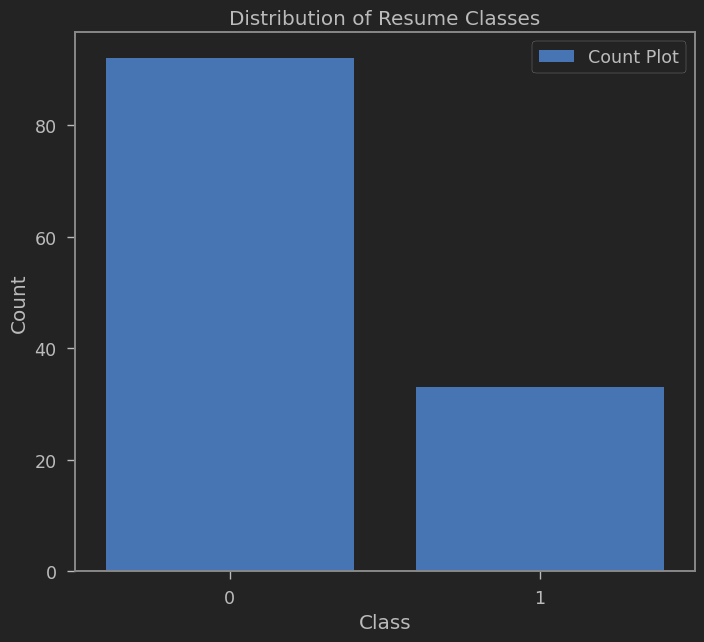

In [47]:
# Plot the counts of flagged vs not flagged
sns.countplot(x=resume_df['class'], label = 'Count Plot')
plt.title('Distribution of Resume Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

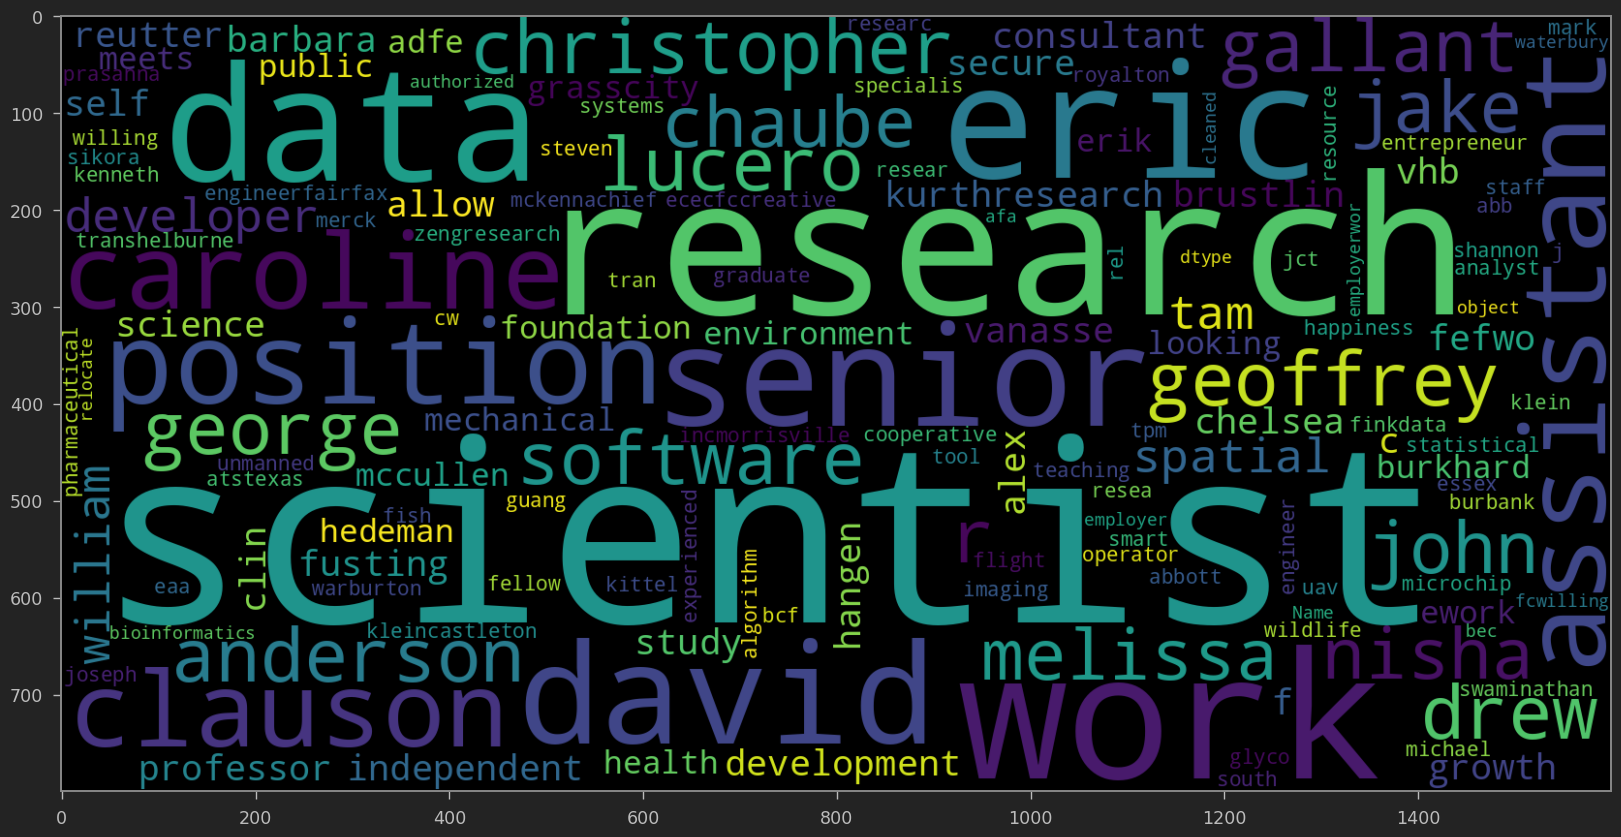

In [48]:
# plot the word cloud for text that is flagged
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(str(resume_df[resume_df['class'] == 1].cleaned))
plt.imshow(wc , interpolation = 'bilinear')

MINI CHALLENGE #3:
- Plot the wordcloud for class #1

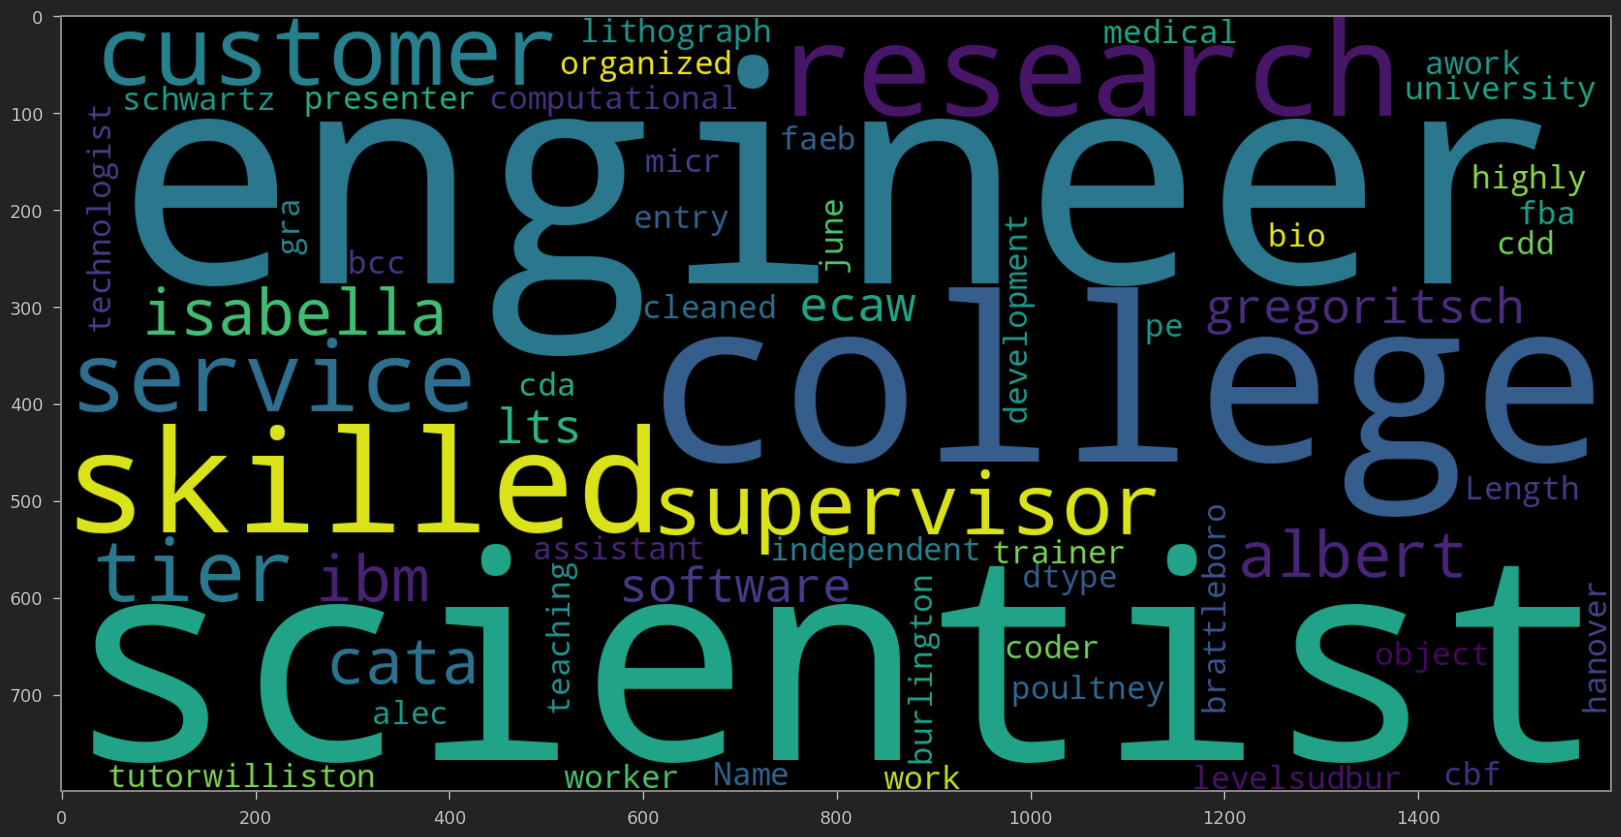

In [49]:
# plot the word cloud for text that is flagged
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(str(resume_df[resume_df['class'] == 0].cleaned))
plt.imshow(wc , interpolation = 'bilinear')

# TASK #6: PREPARE THE DATA BY APPLYING COUNT VECTORIZER

![image.png](attachment:image.png)

In [50]:
# CountVectorizer example
from sklearn.feature_extraction.text import CountVectorizer
sample_data = ['Hello World', 'Hello Hello Hello World world', 'Hello Hello World world world World']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sample_data)

print(vectorizer.get_feature_names_out())
print(X.toarray())

['hello' 'world']
[[1 1]
 [3 2]
 [2 4]]


In [51]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(resume_df['cleaned'])

In [52]:
# Applying CountVectorier to the cleaned text
print(vectorizer.get_feature_names_out())

['aaalac' 'aabb' 'aac' ... 'ãæcomputer' 'ètravel' 'ô_torrent']


In [53]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# TASK #7: UNDERSTAND THE THEORY AND INTUITION BEHIND NAIVE BAYES CLASSIFIERS - PART #1

# TASK #8: UNDERSTAND THE THEORY AND INTUITION BEHIND NAIVE BAYES CLASSIFIERS - PART #2

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

MINI CHALLENGE #4:
- Calculate the probability of the red class (non-retiring).

# TASK#9: TRAIN NAIVE BAYES CLASSIFIER MODEL

In [54]:
X.shape

(125, 11315)

In [55]:
y = resume_df['class']

In [56]:
y.shape

(125,)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [58]:
from sklearn.naive_bayes import MultinomialNB
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

MINI CHALLENGE #5:
- Split the data into 25% testing and 75% training and perform a sanity check



In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (93, 11315)
Shape of X_test: (32, 11315)
Shape of y_train: (93,)
Shape of y_test: (32,)


# TASK #10: ASSESS TRAINED MODEL PERFORMANCE


![image.png](attachment:image.png)

<Axes: >

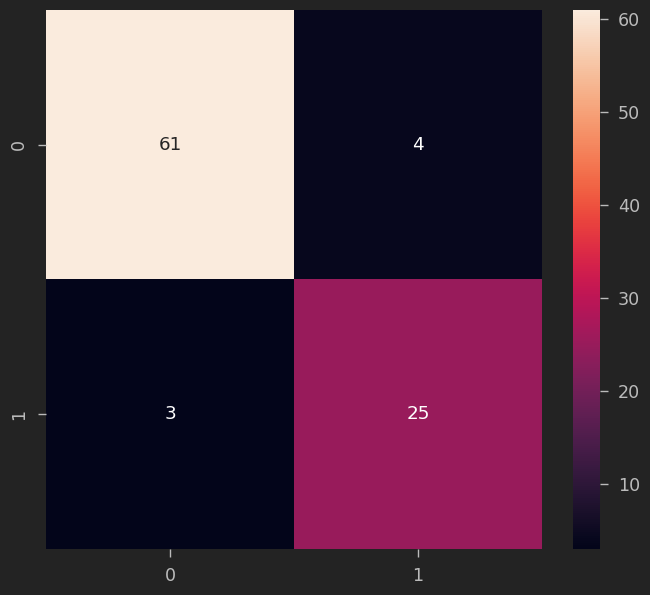

In [60]:
# Predicting the performance on train data
y_predict_train = NB_classifier.predict(X_train)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot = True)

<Axes: >

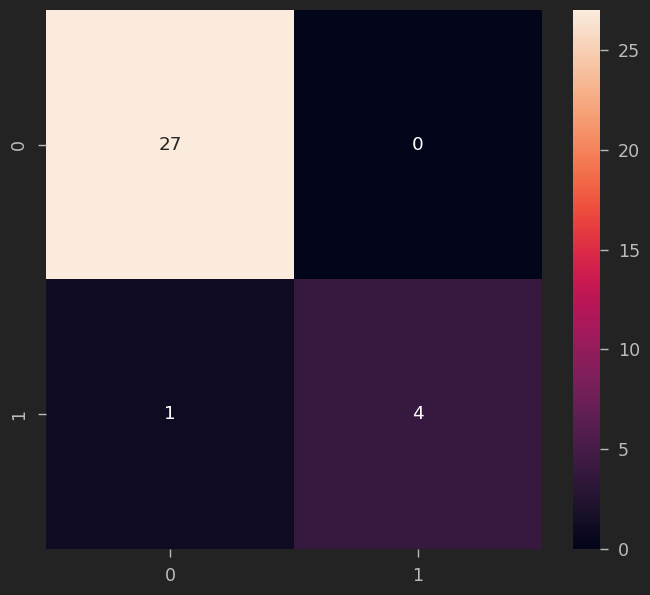

In [61]:
# Predicting the Test set results
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True)

In [62]:
# classification report
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      0.80      0.89         5

    accuracy                           0.97        32
   macro avg       0.98      0.90      0.94        32
weighted avg       0.97      0.97      0.97        32



MINI CHALLENGE #6:
- Retrain the model after spliting the data into 30% testing and 70% training and assess model performance


              precision    recall  f1-score   support

           0       0.76      0.89      0.82        28
           1       0.40      0.20      0.27        10

    accuracy                           0.71        38
   macro avg       0.58      0.55      0.54        38
weighted avg       0.66      0.71      0.67        38



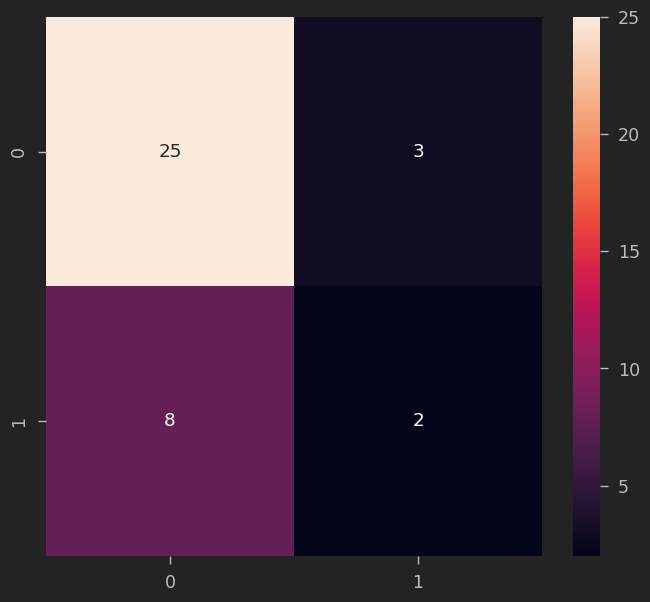

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

# Predicting the Test set results
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True)

# classification report
print(classification_report(y_test, y_predict_test))

# GREAT JOB!

# MINI CHALLENGES SOLUTIONS

MINI CHALLENGE #1 SOLUTION:
- Print the first and last elements in the dataframe.

In [64]:
resume_df.head()

,resume_text,class,cleaned
0,Customer Service Supervisor/Tier - Isabella Ca...,0,customer service supervisor tier isabella cata...
1,Engineer / Scientist - IBM Microelectronics Di...,0,engineer scientist ibm albert gregoritsch ecaw...
2,LTS Software Engineer Computational Lithograph...,0,lts software engineer computational lithograph...
3,TUTORWilliston VT - Email me on Indeed: indee...,0,tutorwilliston alec schwartz awork college bio...
4,Independent Consultant - Self-employedBurlingt...,1,independent consultant self alex reutter fefwo...


In [65]:
resume_df.tail()

,resume_text,class,cleaned
120,Brattleboro VT - Email me on Indeed: indeed.co...,0,brattleboro bcc skilled presenter trainer micr...
121,Research and Teaching Assistant - University o...,0,research teaching assistant university cdd gra...
122,Medical Coder - Highly Skilled - Entry LevelSu...,0,medical coder highly skilled entry levelsudbur...
123,Waterbury VT - Email me on Indeed: indeed.com/...,1,waterbury bec fcwilling relocate work employer...
124,Research and Development Scientist - Burlingto...,0,research development scientist burlington cda ...


MINI CHALLENGE #2 SOLUTION:
- Divide the DataFrame into two, one that belongs to class 0 and 1. Do we have a balanced dataset?

In [66]:
class_0_df = resume_df[resume_df['class']==0]
class_0_df

,resume_text,class,cleaned
0,Customer Service Supervisor/Tier - Isabella Ca...,0,customer service supervisor tier isabella cata...
1,Engineer / Scientist - IBM Microelectronics Di...,0,engineer scientist ibm albert gregoritsch ecaw...
2,LTS Software Engineer Computational Lithograph...,0,lts software engineer computational lithograph...
3,TUTORWilliston VT - Email me on Indeed: indee...,0,tutorwilliston alec schwartz awork college bio...
5,Poultney VT - Email me on Indeed: indeed.com/r...,0,poultney cbf fba organized independent worker ...
...,...,...,...
119,ProfessionalNewbury VT - Email me on Indeed: i...,0,faeb work college hanover june technologist pe...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0,brattleboro bcc skilled presenter trainer micr...
121,Research and Teaching Assistant - University o...,0,research teaching assistant university cdd gra...
122,Medical Coder - Highly Skilled - Entry LevelSu...,0,medical coder highly skilled entry levelsudbur...


In [67]:
class_1_df = resume_df[resume_df['class']==1]
class_1_df

,resume_text,class,cleaned
4,Independent Consultant - Self-employedBurlingt...,1,independent consultant self alex reutter fefwo...
7,StatisticianBurlington VT - Email me on Indeed...,1,secure position allow growth development work ...
10,Barbara KurthResearch Assistant Professor Clin...,1,barbara kurthresearch assistant professor clin...
15,Caroline Clauson Work Study StudentBrattleboro...,1,caroline clauson work study caroline clauson c...
17,Chelsea MartinEnvironmental Scientist - Vanass...,1,chelsea scientist vanasse hangen brustlin vhb ...
18,Christopher Fusting Data Science ConsultantBur...,1,christopher fusting data science christopher f...
23,David GrassCity Research Scientist - Environme...,1,david grasscity research scientist environment...
24,David Lucero Public Health AnalystBurlington V...,1,david lucero public health david lucero work r...
27,Drew BurkhardEnvironmental Scientist Meets Mec...,1,drew scientist meets mechanical drew burkhard ...
31,Eric Anderson Data ScientistBrattleboro VT - E...,1,eric anderson data eric anderson adfe looking ...


MINI CHALLENGE #3 SOLUTION:
- Plot the wordcloud for class #1

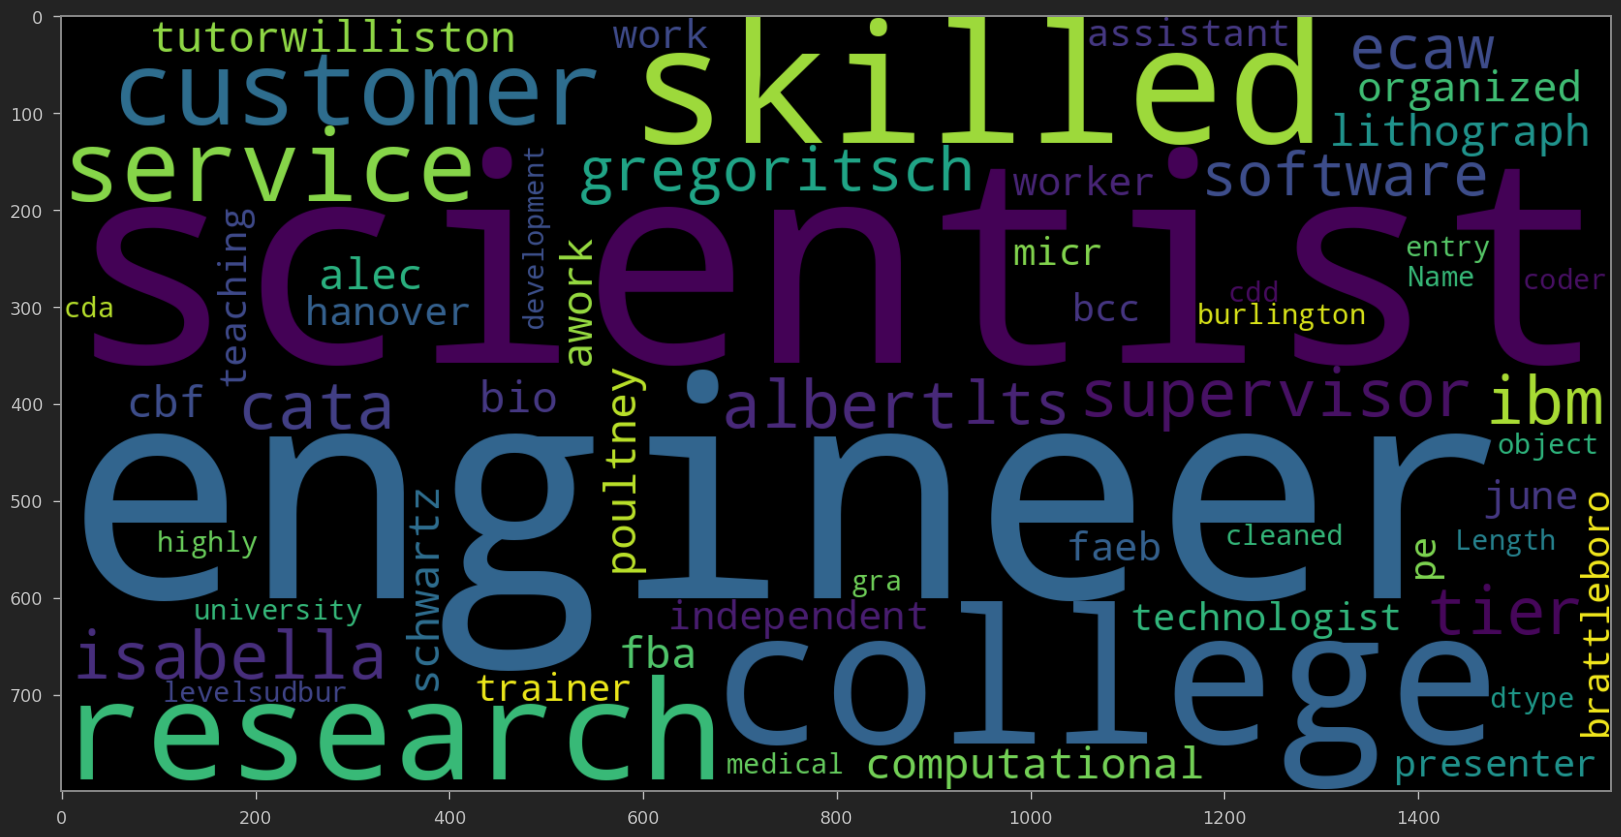

In [68]:
# plot the word cloud for text that is not flagged
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(str(resume_df[resume_df['class'] == 0].cleaned))
plt.imshow(wc , interpolation = 'bilinear')

MINI CHALLENGE #4 SOLUTION:
- Calculate the probability of the red class (non-retiring).

![image.png](attachment:image.png)

MINI CHALLENGE #5 SOLUTION:
- Split the data into 25% testing and 75% training and perform a sanity check


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

MINI CHALLENGE #6 SOLUTION:
- Retrain the model after spliting the data into 30% testing and 70% training and assess model performance


              precision    recall  f1-score   support

           0       0.82      0.97      0.89        29
           1       0.75      0.33      0.46         9

    accuracy                           0.82        38
   macro avg       0.79      0.65      0.68        38
weighted avg       0.81      0.82      0.79        38



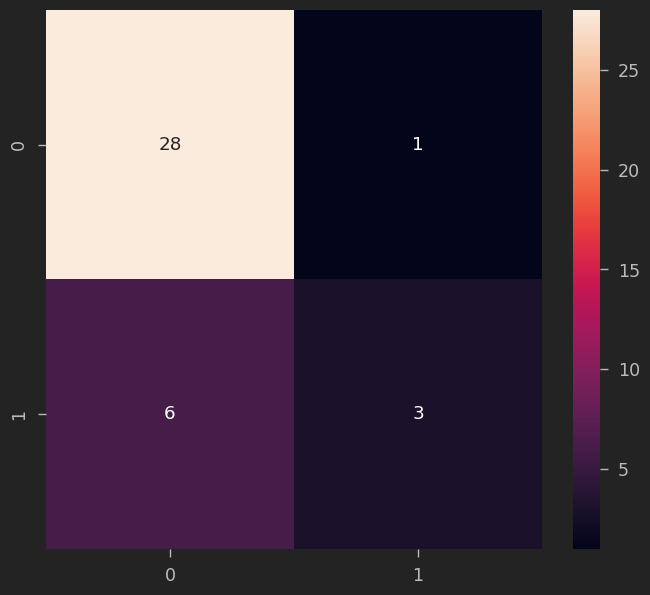

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

# Predicting the Test set results
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True)

# classification report
print(classification_report(y_test, y_predict_test))